[View in Colaboratory](https://colab.research.google.com/github/kintarou/django-starter/blob/master/180303_gan.ipynb)

# Generative Adversarial Network

* https://github.com/znxlwm/pytorch-generative-model-collections
* Generative Adversarial Networks https://arxiv.org/abs/1406.2661
* Generative Adversarial Networks: An Overview
* Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks https://arxiv.org/abs/1511.06434

In [1]:
!pip install torch torchvision
!pip install Pillow==4.1.1

    100% |████████████████████████████████| 484.0MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b71a000 @  0x7fda7162f1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 19.3MB/s 
    100% |████████████████████████████████| 2.0MB 17.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    6% |██                              | 348kB 7.1MB/s eta 0:00:01

    100% |████████████████████████████████| 5.7MB 6.4MB/s 
  Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0


In [2]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## MNIST

* Generatorは62次元のランダムベクトルzを入力として1チャンネルの28x28の画像を出力
* ConvTranspose2d
* 入力は4Dテンソル (N, C1, H1, W1) 出力は4Dテンソル (N, C2, H2, W2)
* H2 = (H1-1)stride - 2padding + kernel_size
* W2 = (W1-1)stride - 2padding + kernel_size
* 1つめのConvTranspose2d $(7-1)*2 - 2*1 + 4 = 14$
* 2つめのConvTranspose2d $(14-1)*2 - 2*1 + 4 = 28$

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

In [6]:
# Generatorのサイズテスト
G = Generator()
input = torch.rand((32, 62))
out = G(input)
print(out.size())

torch.Size([32, 1, 28, 28])


In [7]:
G

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

* 28x28の画像を入力して本物か偽物かを表す0-1の数値を出力する
* MaxPooling2dを使わずにstrideで画像サイズを半分にする

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [9]:
# Discriminatorのサイズテスト
D = Discriminator()
input = torch.rand((32, 1, 28, 28))
out = D(input)
print(out.size())

torch.Size([32, 1])


In [10]:
D

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

### 学習ポイント

* Pooling層をstrided convolution（for D）、fractional-strided convolutions (for G)に置き換える
* G、DともにBatchNormを使う
* 層が深いときはFC層を除去する
* GにはReLUを使う、ただし出力層のみTanh、今回は0-1標準化の画像なのでSigmoid使用（適用済み）
* DにはLeakyReLUを使う
* GeneratorとDiscriminatorはそれぞれoptimizerがある
* 参考先では loss.cuda() しているがlossはパラメータがないのでしなくてOK
* https://discuss.pytorch.org/t/what-exactly-does-loss-cuda-do/7450

In [11]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [12]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [13]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Processing...
Done!


In [14]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(data_loader):
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        # E[log(D(G(z)))
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

### detach()の必要性

* https://github.com/pytorch/examples/issues/116
* D_optimizerにはDのパラメータしか渡しておらず、D_optimizer.step()してもGeneratorのパラメータは更新されないためdetach()しなくても結果はかわらない
* ただ、明示的にdetach()することでfake_imagesを通じてGeneratorに勾配が伝搬することを防ぎ、計算が高速化される

### GANのloss function

* Discriminatorのvalue function（大きい方がよいのでlossではない）
* $L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z)))] \to max$
* D(x)はDiscriminatorで0〜1を返す、1に近いほど入力が本物画像と判定
* G(z)はGeneratorが乱数zから生成した偽物画像を表す
* 本物画像xを入力したときはD(x)が1に近いほどよい（本物と正しく判定）
* 偽物画像G(z)を入力したときはD(G(z))が0に近いほどよい（偽物と正しく判定）
* Generatorのvalue function
* $L_G^{GAN} = E[log(D(G(z)))] \to max$
* 偽物画像G(z)を入力したときにD(G(z))が1に近いほどよい（偽物を本物と騙せた）

In [15]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    # Generatorでサンプル生成
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [16]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

epoch 1, D_loss: 0.7590 G_loss: 1.3458
epoch 2, D_loss: 0.7699 G_loss: 1.4725
epoch 3, D_loss: 0.8692 G_loss: 1.2847
epoch 4, D_loss: 0.8537 G_loss: 1.3200
epoch 5, D_loss: 0.8411 G_loss: 1.3717
epoch 6, D_loss: 0.8227 G_loss: 1.4044
epoch 7, D_loss: 0.8051 G_loss: 1.4356
epoch 8, D_loss: 0.7846 G_loss: 1.4899
epoch 9, D_loss: 0.7714 G_loss: 1.5136
epoch 10, D_loss: 0.7585 G_loss: 1.5605
epoch 11, D_loss: 0.7284 G_loss: 1.5973
epoch 12, D_loss: 0.7186 G_loss: 1.6412
epoch 13, D_loss: 0.6900 G_loss: 1.7103
epoch 14, D_loss: 0.6786 G_loss: 1.7659
epoch 15, D_loss: 0.6695 G_loss: 1.7971
epoch 16, D_loss: 0.6371 G_loss: 1.8375
epoch 17, D_loss: 0.6162 G_loss: 1.9007
epoch 18, D_loss: 0.6010 G_loss: 1.9471
epoch 19, D_loss: 0.5720 G_loss: 2.0230
epoch 20, D_loss: 0.5841 G_loss: 2.0645
epoch 21, D_loss: 0.5460 G_loss: 2.1015
epoch 22, D_loss: 0.5369 G_loss: 2.1595
epoch 23, D_loss: 0.5321 G_loss: 2.1875
epoch 24, D_loss: 0.5082 G_loss: 2.2289
epoch 25, D_loss: 0.5123 G_loss: 2.2656


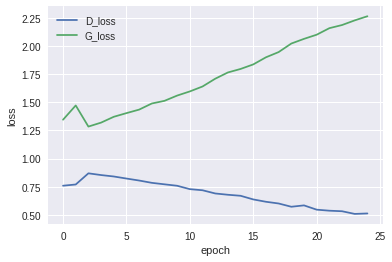

In [17]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

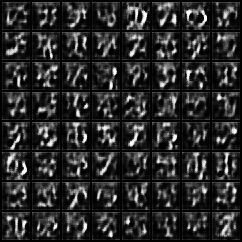

In [18]:
from IPython.display import Image
Image('logs/epoch_001.png')

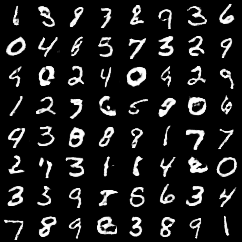

In [19]:
Image('logs/epoch_010.png')

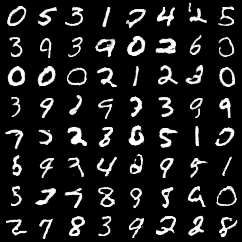

In [20]:
Image('logs/epoch_025.png')

## Fashion MNIST

In [21]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)  

Processing...
Done!


(-0.5, 145.5, 145.5, -0.5)

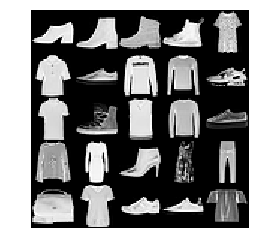

In [22]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [23]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [24]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

epoch 1, D_loss: 0.7610 G_loss: 1.3159
epoch 2, D_loss: 0.9110 G_loss: 1.2642
epoch 3, D_loss: 0.9935 G_loss: 1.1627
epoch 4, D_loss: 1.0107 G_loss: 1.1353
epoch 5, D_loss: 1.0029 G_loss: 1.1549
epoch 6, D_loss: 0.9838 G_loss: 1.1749
epoch 7, D_loss: 0.9761 G_loss: 1.1979
epoch 8, D_loss: 0.9634 G_loss: 1.2045
epoch 9, D_loss: 0.9626 G_loss: 1.2228
epoch 10, D_loss: 0.9513 G_loss: 1.2417
epoch 11, D_loss: 0.9328 G_loss: 1.2656
epoch 12, D_loss: 0.9315 G_loss: 1.2878
epoch 13, D_loss: 0.8999 G_loss: 1.3120
epoch 14, D_loss: 0.8922 G_loss: 1.3478
epoch 15, D_loss: 0.8644 G_loss: 1.3782
epoch 16, D_loss: 0.9370 G_loss: 1.3629
epoch 17, D_loss: 0.8329 G_loss: 1.4315
epoch 18, D_loss: 0.8230 G_loss: 1.4600
epoch 19, D_loss: 0.8100 G_loss: 1.4953
epoch 20, D_loss: 0.7825 G_loss: 1.5338
epoch 21, D_loss: 0.7659 G_loss: 1.5779
epoch 22, D_loss: 0.7462 G_loss: 1.6224
epoch 23, D_loss: 0.7325 G_loss: 1.6633
epoch 24, D_loss: 0.7137 G_loss: 1.6853
epoch 25, D_loss: 0.7457 G_loss: 1.6995


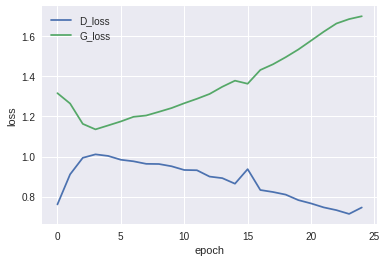

In [25]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

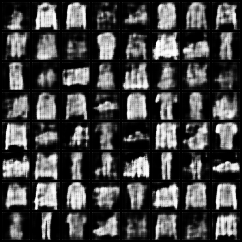

In [26]:
Image('logs/epoch_001.png')

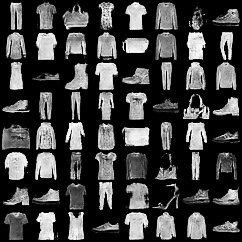

In [27]:
Image('logs/epoch_010.png')

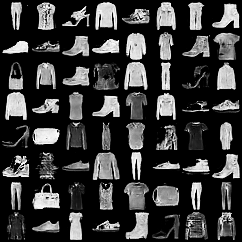

In [28]:
Image('logs/epoch_025.png')

## CelebA

* 事前に下のGoogle Driveを自分のGoogle Driveにコピーしておく
* http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
* ocamlfuseをインストールしてGoogle Driveをマウントする

In [29]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [30]:
# Google DriveのデータをColabのインスタンスにコピーしてくる
!cp drive/Colab\ Notebooks/data/CelebA/Img/img_align_celeba.zip .
!mkdir data/celebA
!unzip img_align_celeba.zip -d data/celebA
!ls data/celebA
!mkdir logs

cp: cannot stat 'drive/Colab Notebooks/data/CelebA/Img/img_align_celeba.zip': No such file or directory
unzip:  cannot find or open img_align_celeba.zip, img_align_celeba.zip.zip or img_align_celeba.zip.ZIP.
mkdir: cannot create directory ‘logs’: File exists


In [31]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [32]:
# load dataset
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
# celebAの下に直接画像ファイルがあってはダメ！
# クラスのディレクトリが入る必要がある（今回はimg_align_celebaでOK）
dataset = datasets.ImageFolder('data/celebA', transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

RuntimeError: ignored

(-0.5, 145.5, 145.5, -0.5)

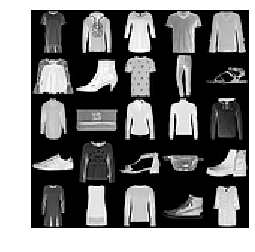

In [33]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [34]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 16 * 16),
            nn.BatchNorm1d(128 * 16 * 16),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc(x)
        return x

In [35]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [36]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

RuntimeError: ignored

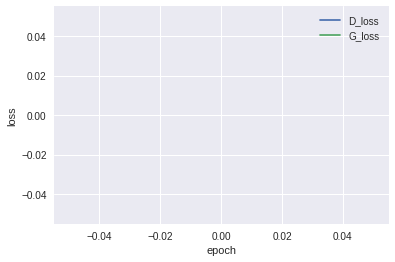

In [37]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

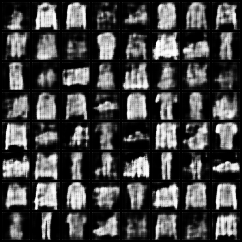

In [38]:
from IPython.display import Image
Image('logs/epoch_001.png')

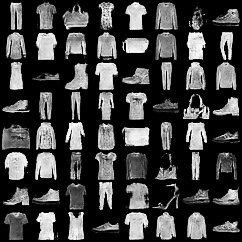

In [39]:
Image('logs/epoch_010.png')

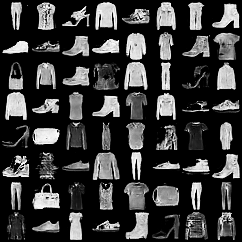

In [40]:
Image('logs/epoch_025.png')